# CNN模型
利用CNN实现情感分类

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np

## 准备预训练的权重

In [3]:
# import gensim

def open_file(filename, mode='r'):
    """
    打开特定文件
    """
    return open(filename, mode, encoding='utf-8', errors='ignore')

def read_vocab(vocab_path):
    """
    读取本地的词汇表
    """
    with open_file(vocab_path) as f:
        words = [_.strip() for _ in f.readlines()]
    word2id = dict(zip(words, range(len(words))))
    id2word = dict(zip(range(len(words)), words))
    return words, word2id, id2word

def get_weight():
    '''
    获取预训练词嵌入权重
    '''
    _, word2idx, idx2word = read_vocab("./dataset/vocab_f.txt")
    wvmodel = gensim.models.KeyedVectors.load_word2vec_format(
        './data/GoogleNews-vectors-negative300.bin.gz', 
        binary=True
    )

    vocab_size = len(word2idx)
    embed_size = 300
    weights = torch.zeros(vocab_size, embed_size)

    for i in range(len(wvmodel.index_to_key)):
        try:
            index = word2idx[wvmodel.index_to_key[i]]
        except:
            continue
        weights[index, :] = torch.from_numpy(wvmodel.get_vector(
            idx2word[word2idx[wvmodel.index_to_key[i]]]))
    # 保存
    torch.save(weights, "./dataset/weights.pt")

    
# 获取权重并保存
# get_weight()

## 模型定义
- CNN
- RNN
- Baseline
- CNN & Inception

In [4]:
class CNN(nn.Module):
    def __init__(self, args, weights):
        '''
        args - 参数
        weights - 预训练权重
        is_att - 是否使用attention
        '''
        super(CNN, self).__init__()
        # 参数设定
        # 词汇表大小
        self.num_word = args.num_word
        # 词向量长度
        self.dim = args.dim
        # 类别数量
        self.num_class = args.num_class
        # 输入channel
        self.num_chan = args.num_chan
        # 卷积核的有关参数
        self.num_kerl = args.num_kerl
        self.kerl_sizes = args.kerl_sizes

        # 定义各层
        # 不使用预训练词向量
        # self.embed = nn.Embedding(self.num_word, self.dim)
        # 使用预训练词向量
        self.embed = nn.Embedding.from_pretrained(weights)
        # 训练过程中对权重进行微调
        self.embed.weight.requires_grad = True
        # 卷积层和线性层
        if args.is_att:
            self.convs = nn.ModuleList(
                [nn.Conv2d(
                    self.num_chan,
                    self.num_kerl,
                    (kerl_size, self.dim * 2)
                ) for kerl_size in self.kerl_sizes]
            )
        else:
            self.convs = nn.ModuleList(
                [nn.Conv2d(
                    self.num_chan,
                    self.num_kerl,
                    (kerl_size, self.dim)
                ) for kerl_size in self.kerl_sizes]
            )
        self.fc = nn.Linear(
            self.num_kerl * len(self.kerl_sizes), 
            self.num_class
        )
        self.dropout = nn.Dropout(args.dropout)

        # attention部分
        self.is_att = args.is_att
        if self.is_att:
            self.att_w = nn.Parameter(
                torch.zeros(self.dim)
            )
            self.tanh = nn.Tanh()

    def forward(self, x):
        # 词嵌入
        x = self.embed(x)
        # attention
        if self.is_att:
            H = x
            M = self.tanh(H)
            a = F.softmax(
                torch.matmul(M, self.att_w),
                dim=1
            ).unsqueeze(-1)
            x = torch.cat((H * a, x), 2)
        # 卷积操作
        x = x.unsqueeze(1)
        x = [
            F.relu(conv(x)).squeeze(3) 
            for conv in self.convs
        ] 
        # 池化
        x = [
            F.max_pool1d(row, row.size(2)).squeeze(2)
            for row in x
        ]  
        # 输出结果
        x = torch.cat(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x


class RNN(nn.Module):
    '''
    用双向LSTM实现RNN,
    加了池化层拥有CNN类似的视野能力
    '''
    def __init__(self, args, weights):
        super(RNN, self).__init__()
        # 参数设定
        # 词汇表大小
        self.num_word = args.num_word
        # 词向量长度
        self.dim = args.dim
        # 类别数量
        self.num_class = args.num_class
        # 隐藏层大小
        self.hidden_size = args.hidden_size
        self.num_layers = args.num_layers

        # 定义各层
        # 不使用预训练词向量
        # self.embed = nn.Embedding(self.num_word, self.dim)
        # 使用预训练词向量
        self.embed = nn.Embedding.from_pretrained(weights)
        # 训练过程中对权重进行微调
        self.embed.weight.requires_grad = True
        # lstm
        self.lstm = nn.LSTM(
            self.dim, 
            self.hidden_size,
            num_layers=self.num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=args.dropout
        )
        self.max_pool = nn.MaxPool1d(179)
        self.fc = nn.Linear(
            self.hidden_size * 2 + self.dim,
            self.num_class
        )

    def forward(self, x):
        # 词嵌入
        tmp = self.embed(x)
        # lstm
        x, _ = self.lstm(tmp)
        # 池化
        x = torch.cat(
            (tmp, x), 2
        )
        x = F.relu(x)
        # 输出结果
        x = x.permute(0, 2, 1)
        x = self.max_pool(x).squeeze()
        x = self.fc(x)
        if x.ndim < 2:
            x = x.unsqueeze(0)
        x = F.log_softmax(x, dim=1)
        return x


class FastText(nn.Module):
    '''
    简单的FastText作为Baseline
    '''
    def __init__(self, args, weights):
        super(FastText, self).__init__()
        # 参数设定
        # 词汇表大小
        self.num_word = args.num_word
        # 词向量长度
        self.dim = args.dim
        # 类别数量
        self.num_class = args.num_class
        # 隐藏层大小
        self.hidden_size = args.hidden_size
        # ngram词表大小
        self.num_gram = args.num_gram

        # 定义各层
        # 不使用预训练词向量
        # self.embed = nn.Embedding(self.num_word, self.dim)
        # 使用预训练词向量
        self.embed = nn.Embedding.from_pretrained(weights)
        # 训练过程中对权重进行微调
        self.embed.weight.requires_grad = True
        # 其他的gram
        self.embed_2gram = nn.Embedding(self.num_gram, self.dim)
        self.embed_3gram = nn.Embedding(self.num_gram, self.dim)
        self.dropout = nn.Dropout(args.dropout)
        self.fc1 = nn.Linear(3 * self.dim, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_class)

        # test
        self.fc = nn.Sequential(
            nn.Linear(self.dim, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_size, self.num_class)
        )
    
    def ngramHash(self, front, back):
        '''
        N-Gram哈希函数
        '''
        return (front * 19260817 + back) % self.num_gram

    def forward(self, x):
        # ngram hash
        # y = torch.roll(x, 1, 1)
        # z = torch.roll(y, 1, 1)
        # # # 词嵌入
        # one_gram = self.embed(x)
        # y = y.map_(x, self.ngramHash)
        # two_gram = self.embed_2gram(y)
        # z = z.map_(y, self.ngramHash)
        # tri_gram = self.embed_3gram(z) # [batch_size, 179, 300]
        # 合并
        # x = torch.cat(
        #     (one_gram, two_gram, tri_gram),
        #     2
        # )
        # # 输出结果
        # x = x.mean(dim=1)
        # x = self.dropout(x)
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        # x = F.log_softmax(x, dim=1)

        # test
        x = self.embed(x)
        x = self.fc(torch.mean(x, dim=1))
        x = F.log_softmax(x, dim=1)

        return x

In [5]:
class InceptionLayer(nn.Module):
    '''
    感知层
    '''
    def __init__(self, in_chan, out_chan):
        super(InceptionLayer, self).__init__()
        # 几个分支
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_chan, out_chan//4, 1),
        )
        self.branch2 = nn.Sequential(
            nn.MaxPool1d(3, 1, 1),
            nn.Conv1d(in_chan, out_chan//4, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_chan, out_chan//4, 1),
            nn.Conv1d(
                out_chan//4, 
                out_chan//4, 
                3, 1, 1
            )
        )
        self.branch4 = nn.Sequential(
            nn.Conv1d(in_chan, out_chan//4, 3, 1, 1),
            nn.Conv1d(
                out_chan//4, 
                out_chan//4, 
                5, 1, 2
            )
        )
        self.out = nn.Sequential(
            nn.ReLU(True)
        )

    def forward(self, x):
        x = torch.cat(
            (
                self.branch1(x),
                self.branch2(x),
                self.branch3(x),
                self.branch4(x),
            ), 1
        )
        x = self.out(x)
        return x


class CNNInception(nn.Module):
    def __init__(self, args, weights):
        '''
        args - 参数
        weights - 预训练权重
        is_att - 是否使用attention
        '''
        super(CNNInception, self).__init__()
        # 参数设定
        # 词汇表大小
        self.num_word = args.num_word
        # 词向量长度
        self.dim = args.dim
        # 类别数量
        self.num_class = args.num_class
        # 输入channel
        self.num_chan = args.num_chan
        # 卷积核的有关参数
        self.num_kerl = args.num_kerl
        self.kerl_sizes = args.kerl_sizes
        self.inception_size = args.inception_size

        # 定义各层
        # 不使用预训练词向量
        # self.embed = nn.Embedding(self.num_word, self.dim)
        # 使用预训练词向量
        self.embed = nn.Embedding.from_pretrained(weights)
        # 训练过程中对权重进行微调
        self.embed.weight.requires_grad = True
        # 卷积层和线性层
        self.convs = nn.Sequential(
                    InceptionLayer(self.dim, self.inception_size),
                    nn.MaxPool1d(179)
                )
        self.dropout = nn.Dropout(args.dropout)
        self.fc = nn.Sequential(
            nn.Linear(
                self.inception_size,
                self.num_class
            ),
        )
        

    def forward(self, x):
        # 词嵌入
        x = self.embed(x)
        # 卷积操作
        x = self.convs(x.permute(0,2,1))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

## 参数设定
- 训练的超参数
- 损失函数和优化器

In [6]:
class CNNConfig:
    '''
    CNN模型参数设定
    '''
    def __init__(self):
        # 共有参数
        # 词汇表大小
        self.num_word = 4955
        # 词向量长度
        self.dim = 300
        # 类别数量
        self.num_class = 7
        # drop out
        self.dropout = 0.5

        # CNN有关参数
        # 输入channel
        self.num_chan = 1
        # 每种卷积核的数量
        self.num_kerl = 100
        self.kerl_sizes = [3, 4, 5]
        # 是否attention
        self.is_att = False
        # inception及隐层大小
        self.inception_size = 1024
        
        # 训练参数设定
        self.num_epoch = 100
        self.lr = 1e-4
        # batch的大小
        self.batch_size = 64
        # 随机种子
        self.seed = 56
        # 是否有cuda
        self.cuda = (
            True if torch.cuda.is_available()
            else False
        )
        # weight decay
        self.weight_decay = 3



class RNNConfig:
    '''
    RNN模型参数设定
    '''
    def __init__(self):
        # 共有参数
        # 词汇表大小
        self.num_word = 4955
        # 词向量长度
        self.dim = 300
        # 类别数量
        self.num_class = 7
        # drop out
        self.dropout = 0.5
        
        # RNN参数
        # 隐藏层大小
        self.hidden_size = 256
        # 层数
        self.num_layers = 2
        
        # 训练参数设定
        self.num_epoch = 100
        self.lr = 1e-3
        # batch的大小
        self.batch_size = 64
        # 随机种子
        self.seed = 56
        # 是否有cuda
        self.cuda = (
            True if torch.cuda.is_available()
            else False
        )
        # weight decay
        self.weight_decay = 0.5


class FastTextConfig():
    '''
    FastText参数设定
    '''
    def __init__(self):
        # 共有参数
        # 词汇表大小
        self.num_word = 4955
        # 词向量长度
        self.dim = 300
        # 类别数量
        self.num_class = 7
        # drop out
        self.dropout = 0.5
        
        # FastText参数
        # 隐藏层大小
        self.hidden_size = 128
        # N-Gram词表大小
        self.num_gram = 250007
        
        # 训练参数设定
        self.num_epoch = 100
        self.lr = 0.0001
        # batch的大小
        self.batch_size = 64
        # 随机种子
        self.seed = 56
        # 是否有cuda
        self.cuda = (
            True if torch.cuda.is_available()
            else False
        )
        # weight decay
        self.weight_decay = 3


# 参数
config = CNNConfig()
# 设定随机种子
torch.manual_seed(config.seed)            # 为CPU设置随机种子
np.random.seed(config.seed)
if config.cuda:
    torch.cuda.manual_seed(config.seed)       # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(config.seed)   # 为所有GPU设置随机种子
# 读取权重
weights = torch.load("./dataset/weights.pt")
# 例化模型
model = CNN(config, weights)
# 损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config.lr,
    weight_decay=config.weight_decay
)

# TensorBoard 可视化
display = False
if display:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('output/model/')
    writer.add_graph(model, torch.ones(1, 179, dtype=torch.int))
    writer.close()
    

## 准备输入数据

In [7]:
# 读入数据
x_train = torch.load("./dataset/train_data_x.pt")
y_train = torch.load("./dataset/train_data_y.pt")
y_train = torch.topk(y_train, 1)[1].squeeze(1)
x_test = torch.load("./dataset/test_data_x.pt")
y_test = torch.load("./dataset/test_data_y.pt")
y_test = torch.topk(y_test, 1)[1].squeeze(1)
x_vali = torch.load("./dataset/vali_data_x.pt")
y_vali = torch.load("./dataset/vali_data_y.pt")
y_vali = torch.topk(y_vali, 1)[1].squeeze(1)


In [8]:
# 数据集
train_data = TensorDataset(x_train, y_train) 
test_data = TensorDataset(x_test, y_test) 
vali_data = TensorDataset(x_vali, y_vali)

train_dataloader = DataLoader(
    train_data, 
    batch_size=config.batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=config.batch_size
)
vali_dataloader = DataLoader(
    vali_data,
    batch_size=config.batch_size
)


## 训练循环

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, config, output=True):
    '''
    训练循环
    '''
    size = len(dataloader.dataset)
    cnt = 0
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # GPU训练
        if config.cuda:
            X = X.to("cuda")
            y = y.to("cuda")
        # 预测和计算损失
        pred = model(X)
        loss = loss_fn(pred, y)
        # 记录正确数量
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        cnt += y.size(0)
        # 后向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 70 == 0:
        if batch * len(X) == 4480:
            # loss, current = loss.item(), batch * len(X)
            current = batch * len(X)
            # correct = (pred.argmax(1) == y).type(torch.float).sum().item()/\
            #     y.size(0)
            if output:
                print(f"Acc: {(100*correct/cnt):>0.1f}% \
                    Avg loss: {train_loss/cnt:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss/cnt, correct/cnt

def test_loop(dataloader, model, loss_fn, is_test, config, output=True):
    '''
    测试或验证循环
    '''
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # GPU训练
            if config.cuda:
                X = X.to("cuda")
                y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    if is_test and output:
        print(
            f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, \
            Avg loss: {test_loss:>8f} \n"
        )
    elif output:
        print(
            f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, \
            Avg loss: {test_loss:>8f} \n"
        )
    return test_loss, correct

In [10]:
# GPU训练
if config.cuda:
    model.to("cuda")
# 统计数据
train_loss = []
train_acc = []
test_loss = []
test_acc = []
vali_loss = []
vali_acc = []
best_epoch = -1
best_acc = -1
# 提前停止
early_stop = 9999
# 开始训练
for t in range(config.num_epoch):
    if t > early_stop:
        break
    print(f"Epoch {t+1}\n-------------------------------")
    x, y = train_loop(train_dataloader, model, loss_fn, optimizer, config)
    train_loss.append(x)
    train_acc.append(y)
    x, y = test_loop(test_dataloader, model, loss_fn, True, config)
    test_loss.append(x)
    test_acc.append(y)
    x, y = test_loop(vali_dataloader, model, loss_fn, False, config)
    vali_loss.append(x)
    vali_acc.append(y)
    if y > best_acc:
        best_acc = y
        best_epoch = t
print("Training Finish!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 19.6%,             Avg loss: 0.030831 

Validation Error: 
 Accuracy: 22.6%,             Avg loss: 0.030472 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 29.8%,             Avg loss: 0.030334 

Validation Error: 
 Accuracy: 27.0%,             Avg loss: 0.030211 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 33.9%,             Avg loss: 0.029910 

Validation Error: 
 Accuracy: 33.2%,             Avg loss: 0.029712 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 38.9%,             Avg loss: 0.029369 

Validation Error: 
 Accuracy: 38.0%,             Avg loss: 0.029210 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 41.1%,             Avg loss: 0.028626 

Validation Error: 
 Accuracy: 41.2%,             Avg loss: 0.028650 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 45.4%,             Avg loss: 0.027849 

Validation Error: 
 Accura

KeyboardInterrupt: 

In [40]:
# 保存模型
# torch.save(model.state_dict(), "./model/fasttext.pt")

In [9]:
# 结果可视化
# model.load_state_dict(torch.load("./model/fasttext.pt"))
from matplotlib import pyplot as plt 
# loss
plt.plot(train_loss, '-', label='Train')
plt.plot(vali_loss, '-', label='Validation')
plt.plot(test_loss, '-', label='Test')
plt.ylabel("Average Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.close()
# acc
plt.plot(train_acc, '-', label='Train')
plt.plot(vali_acc, '-', label='Validation')
plt.plot(test_acc, '-', label='Test')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.close()
# 打印结果
print(best_epoch, "vali:", vali_acc[best_epoch],
    "test:", test_acc[best_epoch], sep=" ")

              precision    recall  f1-score   support

       anger      0.190     0.169     0.179       213
     disgust      0.298     0.295     0.296       217
        fear      0.251     0.231     0.241       212
       guilt      0.208     0.207     0.207       213
         joy      0.259     0.255     0.257       216
     sadness      0.229     0.284     0.254       215
       shame      0.220     0.217     0.218       217

    accuracy                          0.237      1503
   macro avg      0.236     0.237     0.236      1503
weighted avg      0.237     0.237     0.236      1503



<AxesSubplot:>

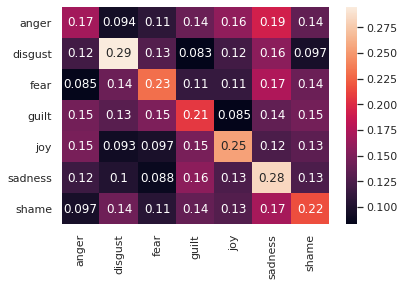

In [21]:
# 计算三项指标和混淆矩阵
from sklearn.metrics import classification_report, \
    precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# 统计
if config.cuda:
    model.to("cuda")
y_true = []
y_pred = []
X_test = []
with torch.no_grad():
    for X, y in test_dataloader:
        # GPU训练
        if config.cuda:
            X = X.to("cuda")
            y = y.to("cuda")
        pred = model(X)
        y_pred.extend(pred.argmax(1).cpu().numpy().tolist())
        y_true.extend(y.cpu().numpy().tolist())
        X_test.append(X)


print(classification_report(
    y_true, y_pred, 
    labels=[0, 1, 2, 3, 4, 5, 6],
    target_names=['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],
    digits=3
))
precision_recall_fscore_support(y_true, y_pred, average='micro')
# 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred, normalize='true',labels=[0,1,2,3,4,5,6])
df = pd.DataFrame(cm, columns=['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],index=['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'])
sns.set()
sns.heatmap(df,annot=True)


## 参数调优

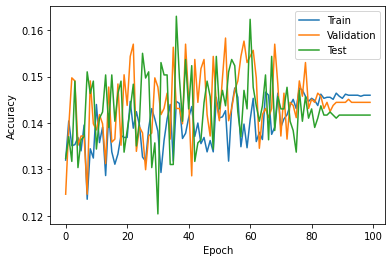

52 vali: 0.158311345646438 test: 0.1437125748502994


In [13]:
# 参数
config = CNNConfig()
# 设定随机种子
torch.manual_seed(config.seed)            # 为CPU设置随机种子
np.random.seed(config.seed)
if config.cuda:
    torch.cuda.manual_seed(config.seed)       # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(config.seed)   # 为所有GPU设置随机种子
# 读取权重
weights = torch.load("./dataset/weights.pt")
# 例化模型
model = CNN(config, weights)
# 损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(
#     model.parameters(), 
#     lr=config.lr,
#     weight_decay=config.weight_decay
# )
optimizer = torch.optim.ASGD(
    model.parameters(), 
    lr=config.lr,
    weight_decay=0
)
# 测试
# GPU训练
if config.cuda:
    model.to("cuda")
# 统计数据
train_loss = []
train_acc = []
test_loss = []
test_acc = []
vali_loss = []
vali_acc = []
best_epoch = -1
best_acc = -1
# 提前停止
early_stop = 99999
# 开始训练
for t in range(config.num_epoch):
    if t > early_stop:
        break
    x, y = train_loop(train_dataloader, model, loss_fn, optimizer, config, output=False)
    train_loss.append(x)
    train_acc.append(y)
    x, y = test_loop(test_dataloader, model, loss_fn, True, config, output=False)
    test_loss.append(x)
    test_acc.append(y)
    x, y = test_loop(vali_dataloader, model, loss_fn, False, config, output=False)
    vali_loss.append(x)
    vali_acc.append(y)
    if y > best_acc:
        best_acc = y
        best_epoch = t
# acc
from matplotlib import pyplot as plt 
plt.plot(train_acc, '-', label='Train')
plt.plot(vali_acc, '-', label='Validation')
plt.plot(test_acc, '-', label='Test')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.close()
# result
print(best_epoch, "vali:", vali_acc[best_epoch],
    "test:", test_acc[best_epoch], sep=" ")
